In [5]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
import json

In [6]:
ground_truth = pl.read_csv('../experiments/experiment40/result.csv')
pws_result = pl.read_csv('../experiments/experiment44/result.csv')
doe_result = pl.read_csv('../experiments/experiment41/result.csv')
infonce_result = pl.read_csv('../experiments/experiment42/result.csv')

In [7]:
with open("../data/ar_data2.json", "r") as file:
    json_data = json.load(file)

Text(0, 0.5, 'MI (bit)')

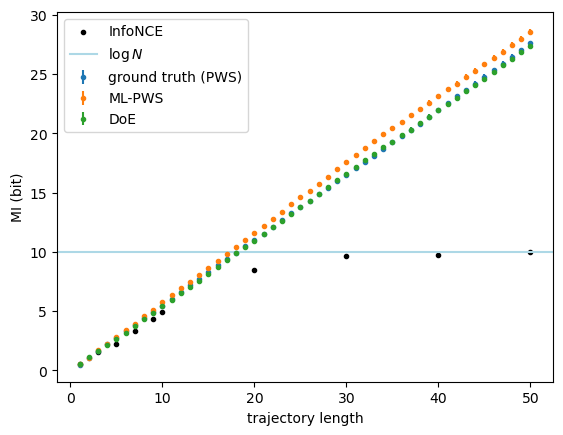

In [11]:
# plt.errorbar(ground_truth['step'], ground_truth['mean'], ground_truth['stderr'], fmt='.', label="ground truth (Variational)")
plt.errorbar(json_data['Time'], json_data['MutualInformation'] / np.log(2), json_data['SEM'] / np.log(2), fmt='.', label="ground truth (PWS)")
plt.errorbar(pws_result['step'], pws_result['mean'] / np.log(2), ground_truth['stderr'] / np.log(2), fmt='.', label="ML-PWS")
plt.errorbar(doe_result['step'], doe_result['mean'] / np.log(2), doe_result['stderr'] / np.log(2), fmt='.', label="DoE")
plt.scatter(infonce_result['step'], infonce_result['mean'] / np.log(2), label="InfoNCE", marker='.', color='black')
plt.axhline(np.log2(1000), label="$\\log N$", color='lightblue')
plt.legend()
plt.xlabel('trajectory length')
plt.ylabel('MI (bit)')
# plt.yscale('log')

## Testing the statistical properties of input data

In [18]:
import torch
import numpy as np
from statsmodels.tsa.stattools import levinson_durbin
import json

EXP_NUM = 43

data = torch.load(f'../experiments/experiment{EXP_NUM}/input_data.pth')
with open(f'../experiments/experiment{EXP_NUM}/parameters.json', 'r') as file:
    params = json.load(file)
s = data['val_s']
x = data['val_x']
params

{'run_info': {'start_time': '2025-08-15T15:20:20.721355+00:00',
  'hostname': 'cluster-new.hollandia.amolf.nl'},
 'ar_coeffs': [0.5, -0.3, 0.2],
 'ar_std': 1.0,
 'gain': 1.0,
 'decay': 0.2,
 'output_noise': 0.2,
 'output_directory': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43',
 'result_path': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43/result.csv',
 'forward_epochs': 500,
 'backward_epochs': 100,
 'hidden_features': 64,
 'num_pairs': 1000,
 'length': 50,
 'seed': 0,
 'estimator': 'ML-PWS'}

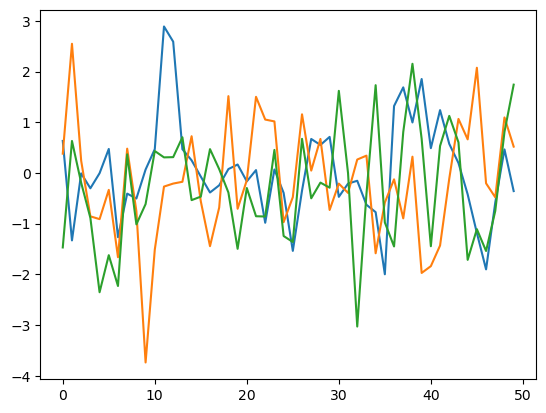

In [26]:
plt.plot(s[:3].T)

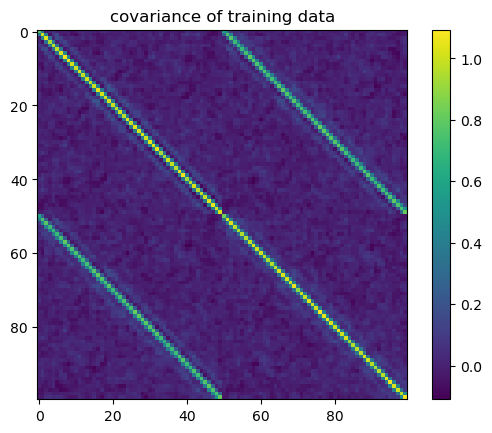

In [19]:
plt.imshow(np.cov(np.concat([s / s.std(), x / x.std()], axis=1).T))
plt.title('covariance of training data')
plt.colorbar()

Text(0.5, 0, 'lag')

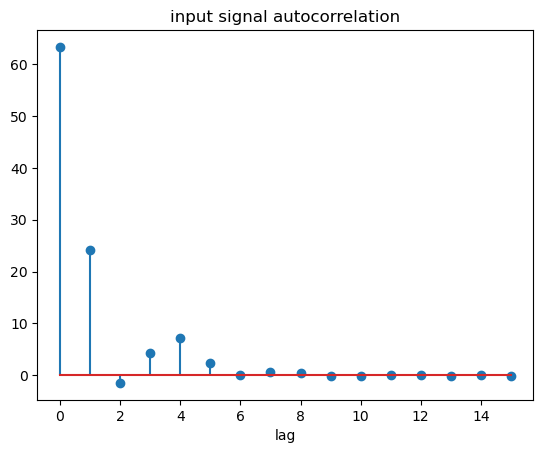

In [20]:
lags = np.arange(-s.shape[-1]+1, s.shape[-1])
max_lags = 15
acov = np.mean(np.stack([np.correlate(s, s, mode='full') for s in s]), axis=0)
pos = np.logical_and(lags >= 0, lags <= max_lags)
plt.stem(lags[pos], acov[pos])
plt.title('input signal autocorrelation')
plt.xlabel('lag')

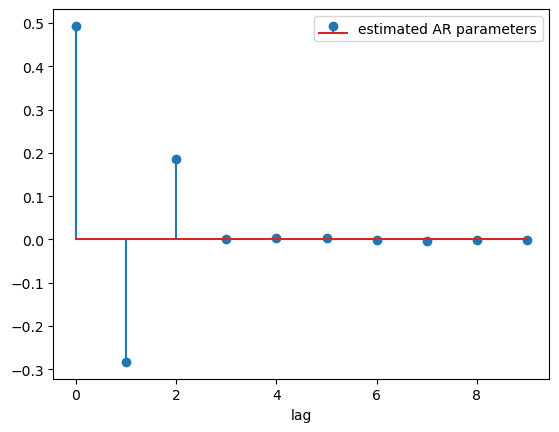

In [21]:
sigma_v, arcoefs, pacf, _, _ = levinson_durbin(acov[pos], isacov=True)
plt.stem(arcoefs, label='estimated AR parameters')
# plt.stem(params['ar_coeffs'], markerfmt='green', label='true AR parameters')
plt.xlabel('lag')
plt.legend()

<BarContainer object of 2 artists>

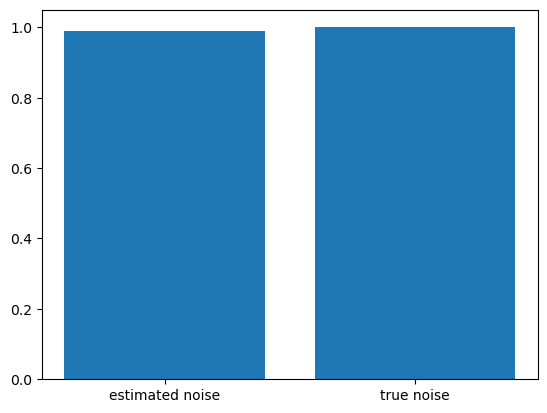

In [22]:
conv_params = np.insert(-np.array(params['ar_coeffs']), 0, 1)
residuals = np.zeros_like(s)
for i in range(residuals.shape[0]):
    residuals[i, :] = np.convolve(s[i], conv_params, mode='same')
plt.bar(['estimated noise', 'true noise'], [np.std(residuals), params['ar_std']])

In [1]:
from ml_pws.models.variational_rnn import VariationalRnn
from flax import nnx
import jax.numpy as jnp
import jax

In [2]:
var_rnn = VariationalRnn(64, 5, 3, nnx.Rngs(0))
var_rnn

VariationalRnn( # Param: 82,419 (329.7 KB), RngState: 4 (24 B), Total: 82,423 (329.7 KB)
  rngs=Rngs( # RngState: 2 (12 B)
    default=RngStream( # RngState: 2 (12 B)
      count=RngCount( # 1 (4 B)
        value=Array(4, dtype=uint32),
        tag="'default'"
      ),
      key=RngKey( # 1 (8 B)
        value=Array((), dtype=key<fry>) overlaying:
        [0 0],
        tag="'default'"
      )
    )
  ),
  encoder_x=RNN( # Param: 4,224 (16.9 KB), RngState: 4 (24 B), Total: 4,228 (16.9 KB)
    cell=SimpleCell( # Param: 4,224 (16.9 KB), RngState: 2 (12 B), Total: 4,226 (16.9 KB)
      in_features=1,
      hidden_features=64,
      dtype=float32,
      param_dtype=float32,
      carry_init=<function zeros at 0x7f5328384a40>,
      residual=False,
      activation_fn=<PjitFunction of <function tanh at 0x7f532859ade0>>,
      kernel_init=<function variance_scaling.<locals>.init at 0x7f532784e5c0>,
      recurrent_kernel_init=<function orthogonal.<locals>.init at 0x7f532784e660>,
      bias_

In [3]:
var_rnn(jnp.zeros((64,50)))

[[-2.0398765 -1.6217306 -2.4277172 ... -1.388919  -1.5709033 -3.2705874]
 [-1.388972  -1.8747089 -1.3866221 ... -2.2939718 -2.0272343 -1.8847442]
 [-3.0416243 -1.5330017 -1.3870598 ... -2.3421874 -2.7394626 -1.462945 ]
 ...
 [-1.3865314 -2.2715564 -1.3863105 ... -1.4147031 -1.626111  -1.4017702]
 [-1.530122  -1.6044998 -1.4457641 ... -1.7667098 -1.9520143 -1.6547644]
 [-2.0216088 -2.2907245 -1.8510842 ... -3.935502  -1.5236342 -1.5514379]], [[-1.7062215   0.98958224 -2.2218711  ...  0.10248346  0.87260187
   3.1898847 ]
 [-0.10351854  1.4552561   0.03620714 ...  2.0523012  -1.6879072
   1.4713365 ]
 [-2.9384356   0.7754466  -0.05533941 ...  2.1142347  -2.5955577
  -0.55726075]
 ...
 [-0.030783    2.0231676  -0.00802972 ...  0.33789712 -0.9991073
  -0.24912544]
 [ 0.7676152   0.9513264   0.49014914 ...  1.2730082   1.5761046
   1.0596143 ]
 [ 1.6797167  -2.0480947  -1.4168844  ...  3.895233   -0.74969876
   0.8239865 ]]
[[-2.0398765 -1.5892408 -2.4252784 ... -1.3662347 -1.5594702 -3.269

(Array([[-2.0398765, -1.3830045, -2.4194105, ..., -1.2776251, -1.5190451,
         -3.3262596],
        [-1.3889728, -1.8605591, -1.571976 , ..., -2.2158854, -2.1776378,
         -1.6502051],
        [-3.0416243, -1.1337769, -1.268265 , ..., -2.2909544, -2.8715477,
         -1.1395867],
        ...,
        [-1.3865314, -2.2673619, -1.6445417, ..., -1.8650625, -1.7563539,
         -1.2817186],
        [-1.5301225, -1.7063711, -1.629127 , ..., -1.7779646, -2.0991576,
         -1.9417868],
        [-2.0216088, -2.4554892, -1.5674236, ..., -3.9345758, -1.8711877,
         -1.4846264]], dtype=float32),
 Array([[-1.7062215 ,  0.94255614, -2.2743495 , ...,  0.08939721,
          0.8051756 ,  3.2796745 ],
        [-0.10351855,  1.4478667 , -0.18012926, ...,  1.749403  ,
         -2.3990119 ,  1.2017759 ],
        [-2.9384356 ,  0.7327002 , -0.06304771, ...,  2.0273697 ,
         -3.4706903 , -0.32182208],
        ...,
        [-0.03078324,  2.018622  , -0.34871468, ..., -0.33784318,
         

In [ ]:
def forward(model, x):
    # Make input tensor of shape [batch_size, seq_length, 1]
    x = x.reshape((-1, x.shape[-1]) + (1,))

    # apply reverse rnn to x
    h_x = model.encoder_x(x)

    epsilon = jax.random.logistic(model.rngs(), shape=x.shape[:-1])
    logp = jax.scipy.stats.logistic.logpdf(epsilon)

    @nnx.scan
    def scan_fn(carry, rnn_block: nnx.RNN):
        logp, epsilon = carry
        rnn_input = jnp.concatenate((jnp.expand_dims(epsilon, -1), h_x), axis=-1)
        (log_jac, preds) = rnn_block(rnn_input, return_carry=False, rngs=nnx.Rngs(0))
        return (logp - log_jac, preds), None

    (logp, preds), _ = scan_fn((logp, epsilon), model.decoder_rnn)
    return logp, preds

In [12]:
graphdef, state = nnx.graph.split(var_rnn.decoder_rnn)
jax.tree_util.tree_map(lambda x: x.shape, state)

State({
  'cell': {
    'cell': {
      'dense_h': {
        'kernel': VariableState(
          type=Param,
          value=(3, 64, 192)
        )
      },
      'dense_i': {
        'bias': VariableState(
          type=Param,
          value=(3, 192)
        ),
        'kernel': VariableState(
          type=Param,
          value=(3, 65, 192)
        )
      }
    },
    'transform': {
      'log_s': {
        'bias': VariableState(
          type=Param,
          value=(3, 5)
        ),
        'kernel': VariableState(
          type=Param,
          value=(3, 64, 5)
        )
      },
      'log_scale': {
        'bias': VariableState(
          type=Param,
          value=(3, 1)
        ),
        'kernel': VariableState(
          type=Param,
          value=(3, 64, 1)
        )
      },
      'mu': {
        'bias': VariableState(
          type=Param,
          value=(3, 5)
        ),
        'kernel': VariableState(
          type=Param,
          value=(3, 64, 5)
        )
 

In [13]:
forward(var_rnn, jnp.zeros((64,50)))

AttributeError: 'bool' object has no attribute 'carry'